In [14]:
import os

notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '../'))
os.chdir(project_root)

import sys
sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['figure.figsize'] = (40,6)

from killed_diffusion import killed_diffusion

In [40]:
# Parameters:
K=100.0
r=0.05
T=1.0
sigma=0.22
N=500
M=15000
L=80
B=120

In [41]:
cuo = []
underlying = []
for i in range(600):
    S0 = 0.2 * i + 30.0
    price = killed_diffusion.price_barrier_call_up_and_out(S0, K, r, T, sigma, N, M, B)
    cuo.append(price)
    underlying.append(S0)

In [43]:
cuo_gobet = []
underlying = []
for i in range(600):
    S0 = 0.2 * i + 30.0
    price = killed_diffusion.price_barrier_call_up_and_out_gobet(S0, K, r, T, sigma, N, M, B, k_limit=10)
    cuo_gobet.append(price)
    underlying.append(S0)

In [42]:
cuo_bs = []
underlying = []
for i in range(600):
    S0 = 0.2 * i + 30.0
    price = killed_diffusion.bs_barrier_call_up_and_out(S0, K, r, T, sigma, B)
    cuo_bs.append(price)
    underlying.append(S0)

Text(0.5, 1.0, 'Barrier option price - Call up-and-out with underlying $S_0=100$, barrier $B=120$')

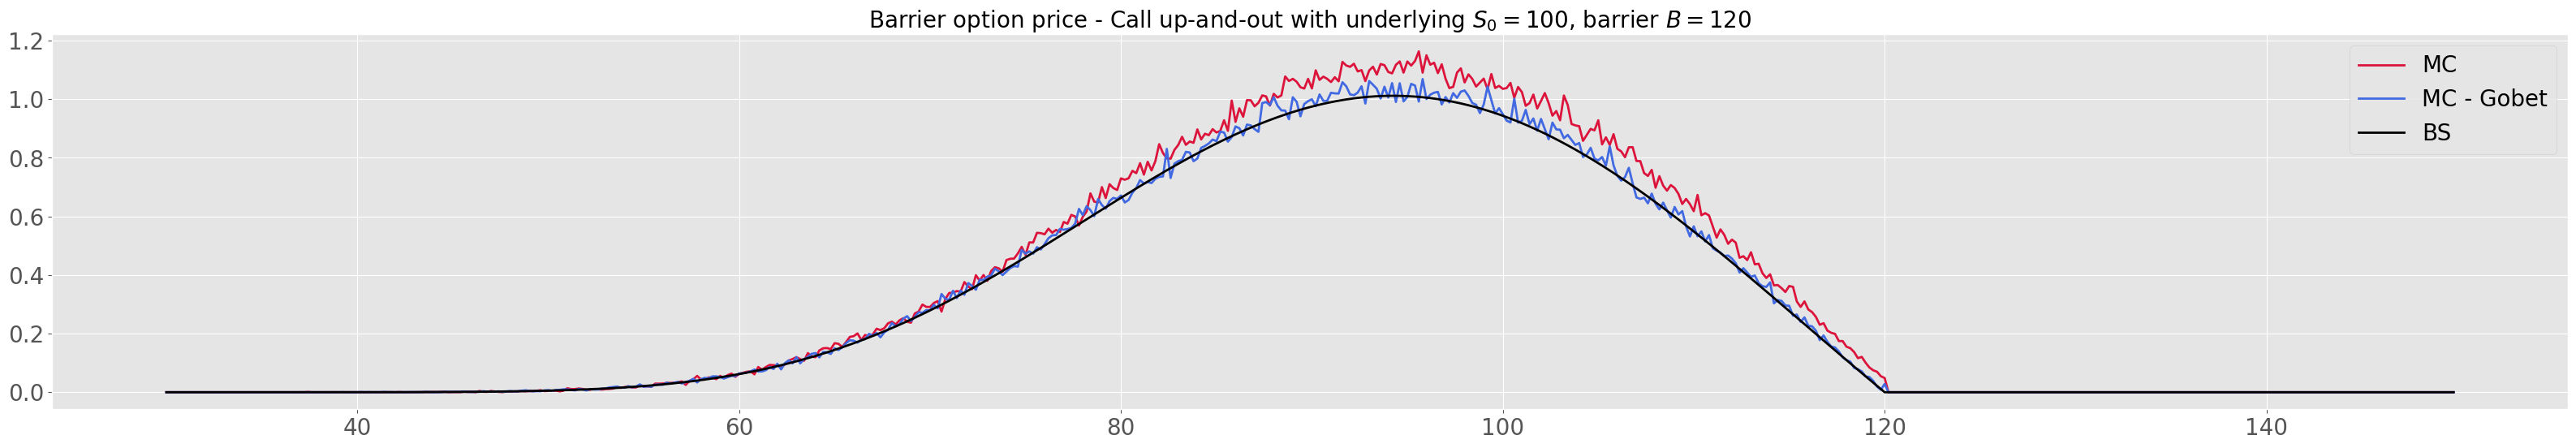

In [55]:
fig, ax = plt.subplots()
ax.plot(underlying, cuo, c='crimson', label='MC')
ax.plot(underlying, cuo_gobet, c='royalblue', label='MC - Gobet')
ax.plot(underlying, cuo_bs, c='black', label='BS')
ax.legend()
ax.set_title(r'Barrier option price - Call up-and-out with underlying $S_0=100$, barrier $B=120$')

In [56]:
fig.savefig("killed_diffusion/report/img/cuo_mc.pdf", format="pdf", bbox_inches='tight')